In [2]:
import os
import sys
import re

NOTEBOOKS_DIR = os.getcwd()
REPO_DIR = os.path.dirname(os.path.abspath(NOTEBOOKS_DIR))
DATA_INGESTION_PACKEGE_DIR = os.path.join(REPO_DIR, "data_ingestion")

sys.path.append(DATA_INGESTION_PACKEGE_DIR)

In [3]:
from langchain_google_vertexai import ChatVertexAI, VertexAIEmbeddings
from langchain_community.document_loaders.pdf import PyMuPDFLoader
from langchain_core.prompts import ChatPromptTemplate


from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_community.vectorstores import Chroma, FAISS
from langchain_core.documents import Document
from langchain.retrievers.multi_query import MultiQueryRetriever

from embedding import EmbeddingClient

from settings import config

from IPython.display import display, Markdown

In [4]:
doc = PyMuPDFLoader("Assignment2 - Spring 2024.pdf", extract_images=True)
docs = doc.load_and_split()

In [5]:
EMBEDDING_QPM = 1200
EMBEDDING_NUM_BATCH = 5

embeddings = VertexAIEmbeddings(
    model_name="textembedding-gecko@003",
    project=config.PROJECT_ID,
    location=config.PROJECT_LOCATION,
    credentials=config.CREDENTIALS,
)

vectorstore = Chroma.from_documents(docs, embedding=embeddings)
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 4})

In [6]:
import base64
import io
from langchain_core.messages import HumanMessage, SystemMessage
from PIL import Image

from pypdf import PdfReader


reader = PdfReader("Assignment2 - Spring 2024.pdf")

for i in range(len(reader.pages)):
    page = reader.pages[i]

    for j, img in enumerate(page.images):
        image = Image.open(io.BytesIO(img.data))
        rgb_image = image.convert("RGB")
        rgb_image.save(f"page{i}_img{j}.jpg")

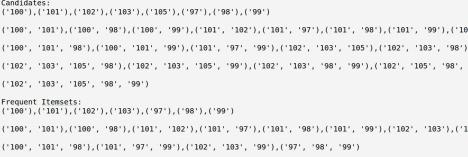

In [7]:
Image.open("page2_img0.jpg")

In [8]:
def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = [
        {
            "type": "text",
            "text": (
                "You are a teaching assistant at the University of Southern California for course DSCI 553: Foundations & Applications of Data Mining." 
                "Your purpose is to help students easily navigate and understand the assignment and resolve queries revolving that."
                "Use the following pieces of context to answer the question at the end."
                "If you don't know the answer, just say that you don't know, don't try to make up an answer."
                "You will be given a mix of text, tables, and image(s) usually of charts or graphs.\n"
                "Use this information to provide investment advice related to the user's question. \n"
                f"User-provided question: {data_dict['question']}\n\n"
                "Text and / or tables:\n"
                f"{formatted_texts}"
            ),
        }
    ]

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            messages.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )
    return [HumanMessage(content=messages)]


def image_summarize(img_base64, prompt):
    """Make image summary"""
    model = ChatVertexAI(model_name="gemini-pro-vision", credentials=config.CREDENTIALS)

    msg = HumanMessage(
        content=[
            {"type": "text", "text": prompt},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
            },
        ]
    )

    return model.invoke([msg]).content

In [9]:
image_base64 = encode_image("page1_img0.jpg")

prompt = """You are an teaching assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a detailed summary of the image that is well optimized for retrieval."""

result = image_summarize(image_base64, prompt)
display(Markdown(result))

 The image contains a table with 6 rows and 2 columns. The header of the table is user id and business id. The data in the table is as follows:
- user id 1, business id 100
- user id 1, business id 98
- user id 1, business id 101
- user id 1, business id 102
- user id 2, business id 101
- user id 2, business id 99

In [10]:
llm_text = ChatVertexAI(
    model="gemini-pro", credentials=config.CREDENTIALS, temperature=0.0, streaming=True, max_output_tokens=2048
)
template = """
You are a teaching assistant at the University of Southern California for course DSCI 553: Foundations & Applications of Data Mining. 
Your purpose is to help students easily navigate and understand the assignment and resolve queries revolving that.

Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.

```
{context}
```

{question}.
"""
prompt = ChatPromptTemplate.from_template(template)

rag_chain = {"context": retriever, "question": RunnablePassthrough()} | prompt | llm_text | StrOutputParser()

llm_vision = ChatVertexAI(
    model_name="gemini-pro-vision",
    temperature=0.0,
    credentials=config.CREDENTIALS,
    max_output_tokens=2048,
    streaming=True,
)

full_chain = RunnablePassthrough() | llm_vision | StrOutputParser() | rag_chain

In [11]:
prompt = """You are an teaching assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a detailed summary of the image that is well optimized for retrieval.
    """

img_base64 = encode_image("page3_img0.jpg")

msg = HumanMessage(
    content=[
        {"type": "text", "text": prompt},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
        },
    ]
)

result = full_chain.invoke([msg])
display(Markdown(result))

 The table has three columns: DATE-CUSTOMER_ID, PRODUCT_ID.
The DATE-CUSTOMER_ID column contains the following values:
- 12/1/00-868266
- 12/1/00-1199833
- 12/1/00-249713

The PRODUCT_ID column contains the following values:
- 8888215880127
- 648636100154
- 4710032500879

In [12]:
message = HumanMessage(
    content=[
        {
            "question": "There are how many tasks in these assignment and what is desired output format for each task?",
        }
    ]
)

result = rag_chain.invoke(
    "Give me a detailed description of all the task in this assignment. What is the output format for task1 and task2? How to execute solution files for both tasks using sprak-submit?"
)
display(Markdown(result))
# result

 **Task 1: Simulated data**

* Build two kinds of market-basket models.
* Input: Two CSV files (small1.csv and small2.csv) provided in Vocareum under ‘/resource/asnlib/publicdata’.
* Output: 
 - Runtime: the total execution time from loading the file till finishing writing the output file. Print the runtime in the console with the “Duration” tag, e.g., “Duration: 100”.
 - Output file: Same format as task 1. Both the intermediate results and final results should be saved in ONE output result file.

**Task 2: Real-world data**

* Apply the SON Algorithm code to the filtered market-basket model.
* Input:
 - Filter threshold: Integer that is used to filter out qualified users
 - Support: Integer that defines the minimum count to qualify as a frequent itemset.
 - Input file path: This is the path to the input file including path, file name and extension.
 - Output file path: This is the path to the output file including path, file name and extension.
* Output: 
 - Runtime: the total execution time from loading the file till finishing writing the output file. Print the runtime in the console with the “Duration” tag, e.g., “Duration: 100”.
 - Output file: Same format as task 1. Both the intermediate results and final results should be saved in ONE output result file.

**Execution**

* Python:
 ```
/opt/spark/spark-3.1.2-bin-hadoop3.2/bin/spark-submit
task2.py
<filter threshold>
<support> <input_file_path> <output_file_path>
```
* Scala:
 ```
spark-submit
--class
task2 hw2.jar
<filter threshold> <support> <input_file_path>
<output_file_path>
```

In [13]:
multi_query_retriever = MultiQueryRetriever.from_llm(retriever=retriever, llm=llm_text)

# Create RAG chain
chain_multimodal_rag = (
    {
        "context": multi_query_retriever | RunnableLambda(split_image_text_types),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(img_prompt_func)
    | llm_vision
    | StrOutputParser()
)

In [15]:
query = """
What is the assignment about? 
What are basic requirements for this assignment?
When is the submission deadline?
How to take a deadline extension?
"""

res = chain_multimodal_rag.invoke(query)
display(Markdown(res))

**Assignment Overview**

This assignment requires you to implement the SON Algorithm using the Spark Framework to identify frequent itemsets in two datasets:

* A simulated dataset
* A real-world Ta Feng dataset

**Basic Requirements**

* Use Python as the programming language.
* Use only standard Python libraries. There is a 10% bonus if you also submit a Scala implementation.
* Use Spark RDDs only (no Spark DataFrames or DataSets).
* Do not share code with other students.

**Assignment Tasks**

**Task 1: Simulated Data**

* Build two types of market-basket models using two provided CSV files.

**Task 2: Ta Feng Data**

* Preprocess the Ta Feng dataset to create a new CSV file with the following format:
    * Header: "DATE-CUSTOMER_ID, PRODUCT_ID"
    * Data: Each line represents a single transaction (DATE-CUSTOMER_ID, PRODUCT_ID)
* Apply the SON Algorithm to the preprocessed dataset and output the following:
    * Runtime (duration from file loading to output writing)
    * Output file containing both the intermediate and final results

**Submission Deadline**

February 23, 23:59 PM PST

**Deadline Extension**

You have five free 5-day deadline extensions available. To use an extension, submit a request using the following form: https://forms.gle/ESmZ4rVf6EGV6Ea18